In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## Import Data

In [2]:
#%time df = pd.read_csv('../data/twcs.csv')

## EDA

In [3]:
#df.shape

In [4]:
#df.columns.tolist()

In [5]:
#df.head()

In [6]:
#df.info()

In [7]:
#%time df['date'] = pd.to_datetime(df.created_at)

In [8]:
#df.to_pickle('../data/tweets.pkl')

### Import Pickle

In [9]:
df = pd.read_pickle('../data/tweets.pkl')

In [10]:
df.drop('created_at',axis=1,inplace=True)

In [11]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date
0,1,sainsburys,False,@83897 ...He'll pass your thanks on to them an...,NaN,2.0,2017-11-03 19:56:25
1,2,83897,True,@sainsburys Sorry no. It was the staff on at t...,"1,3",4.0,2017-11-02 19:52:44
2,4,sainsburys,False,@83897 How nice! Did you catch their name at a...,2,5.0,2017-11-02 19:15:01
3,5,83897,True,Lovely friendly staff @sainsburys cafe Bretton...,4,NaN,2017-11-02 13:08:24
4,6,sainsburys,False,@83898 Oh no! Sorry about that Tom. Could you ...,7,8.0,2017-11-03 19:51:06


In [12]:
df.head()

,tweet_id,author_id,inbound,text,response_tweet_id,in_response_to_tweet_id,date
0,1,sainsburys,False,@83897 ...He'll pass your thanks on to them an...,NaN,2.0,2017-11-03 19:56:25
1,2,83897,True,@sainsburys Sorry no. It was the staff on at t...,"1,3",4.0,2017-11-02 19:52:44
2,4,sainsburys,False,@83897 How nice! Did you catch their name at a...,2,5.0,2017-11-02 19:15:01
3,5,83897,True,Lovely friendly staff @sainsburys cafe Bretton...,4,NaN,2017-11-02 13:08:24
4,6,sainsburys,False,@83898 Oh no! Sorry about that Tom. Could you ...,7,8.0,2017-11-03 19:51:06


In [13]:
df['month'] = df.date.dt.month

### Tweets by Month

In [14]:
df.inbound.value_counts()

True     1038443
False     865847
Name: inbound, dtype: int64

In [15]:
inboundDF = df[df.inbound == True]

In [16]:
inboundDF.shape

(1038443, 8)

In [17]:
monthGroup = df.groupby('month').inbound.count().reset_index()

In [18]:
monthGroup

,month,inbound
0,1,279
1,2,318
2,3,257
3,4,408
4,5,505
5,6,545
6,7,880
7,8,2046
8,9,12812
9,10,1252713


Text(0,0.5,'Inbound Tweets')

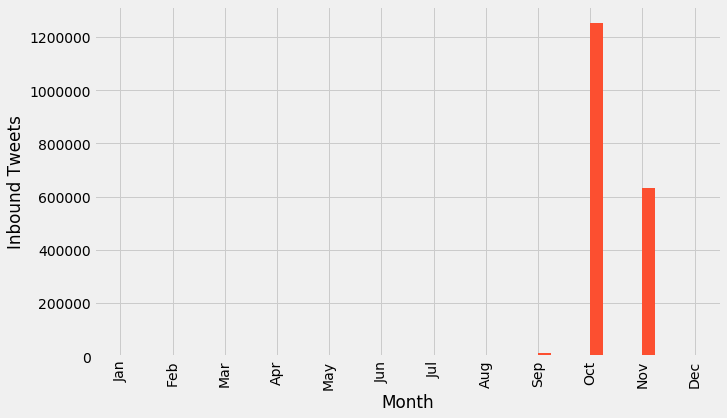

In [19]:
month_ticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(12),month_ticks)
plt.xlabel('Month')
plt.ylabel('Inbound Tweets')

### Tweets by Day

In [20]:
df['day'] = df.date.dt.dayofweek

In [21]:
dayGroup = df.groupby('day').inbound.count().reset_index()

Text(0,0.5,'Inbound Tweets')

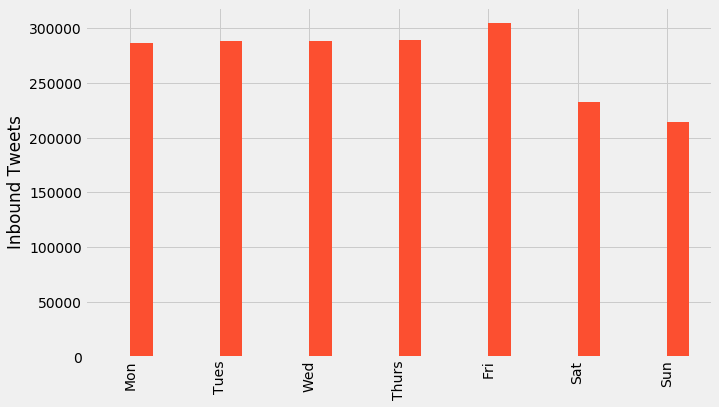

In [22]:
day_ticks = ['Mon','Tues','Wed','Thurs','Fri','Sat','Sun']
dayGroup.plot(kind='bar',figsize=(10,6),legend=False)
plt.xticks(range(7),day_ticks)
#plt.xlabel('Day')
plt.ylabel('Inbound Tweets')

### Tweets by Company

In [23]:
companyGroup = df.groupby('author_id').inbound.count().reset_index()

In [24]:
companyGroup = companyGroup.loc[companyGroup.iloc[:,0].str.contains(r'(^\D{6})')]
companyGroup.sort_values('inbound',ascending=False,inplace=True)

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


In [25]:
companyGroup.shape

(102, 2)

In [26]:
companyGroup

,author_id,inbound
492351,AmazonHelp,112849
492353,AppleSupport,79150
492428,Uber_Support,34885
492420,SpotifyCares,29494
492352,AmericanAir,25807
492421,TMobileHelp,24609
492442,comcastcares,22923
492376,British_Airways,21383
492419,SouthwestAir,20265
492369,Ask_Spectrum,18136


## Text Processing

In [27]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string

### Stop Words

In [28]:
stop = set(stopwords.words('english'))

In [29]:
exclude = set(string.punctuation)

In [30]:
lemma = WordNetLemmatizer()

In [31]:
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [32]:
%time doc_clean = [clean(doc).split() for doc in df.textxt]  

In [36]:
doc_clean[-1][:]

['99458', 'hope', 'enjoy', 'it', 'rob', '🍕']